In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean


In [16]:
data1=pd.read_csv("D:\sih\Book1.csv")
df = pd.DataFrame(data = data1)

In [50]:
df.set_index('u c_ timestamp',inplace=True)

In [51]:

df.drop(('temp') ,axis=1, inplace=True)
df.drop(('direct horizontal'), axis=1, inplace=True)
df.drop(('diffuse horizontal'), axis=1, inplace=True)


KeyError: "['temp'] not found in axis"

In [52]:
df.head()

,Temperature,irradiance,Wind speed in m/s
u c_ timestamp,,,
01-01-2015 00:00,14.664,0.0,0.0
01-01-2015 01:00,14.052,0.0,0.0
01-01-2015 02:00,13.581,0.0,0.0
01-01-2015 03:00,13.197,0.0,4.0
01-01-2015 04:00,12.750,0.0,0.0


In [53]:
target_names = ['Temperature', 'irradiance', 'Wind speed in m/s']

In [54]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [55]:
df_targets = df[target_names].shift(-shift_steps)

In [56]:

x_data = df.values[0:-shift_steps]

In [57]:

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (43800, 3)


In [58]:
y_data = df_targets.values[:-shift_steps]

In [59]:

print(type(y_data))
print("Shape:", y_data.shape)


<class 'numpy.ndarray'>
Shape: (43800, 3)


In [60]:

num_data = len(x_data)
num_data

43800

In [61]:
train_split = 0.9

In [62]:

num_train = int(train_split * num_data)
num_train

39420

In [63]:

num_test = num_data - num_train
num_test

4380

In [64]:

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

43800

In [65]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

43800

In [66]:
num_x_signals = x_data.shape[1]
num_x_signals

3

In [67]:
num_y_signals = y_data.shape[1]
num_y_signals

3

In [68]:
x_scaler = MinMaxScaler()

In [69]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [70]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [71]:
x_test_scaled = x_scaler.transform(x_test)

In [72]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [73]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(39420, 3)
(39420, 3)


In [74]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [75]:
batch_size = 150

In [76]:

sequence_length = 24 * 7 * 2
sequence_length

336

In [77]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [78]:
x_batch, y_batch = next(generator)

In [80]:
print(x_batch.shape)
print(y_batch.shape)

(150, 336, 3)
(150, 336, 3)


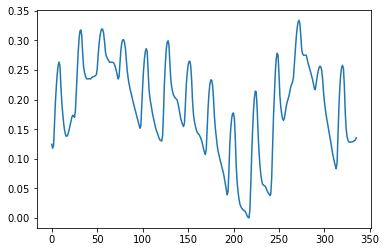

In [81]:

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

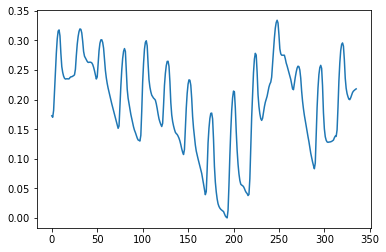

In [82]:

seq = y_batch[batch, :, signal]
plt.plot(seq)

In [83]:

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [84]:
model = Sequential()

In [85]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [86]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [87]:

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [88]:
warmup_steps = 50

In [89]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [90]:
optimizer = RMSprop(lr=1e-3)

In [91]:

model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [92]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         794112    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 795,651
Trainable params: 795,651
Non-trainable params: 0
_________________________________________________________________


In [93]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [94]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [95]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [96]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [97]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [98]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0211
Epoch 00001: val_loss improved from inf to 0.01029, saving model to 23_checkpoint.keras
100/100 [==============================] - 302s 3s/step - loss: 0.0211 - val_loss: 0.0103 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0080
Epoch 00002: val_loss improved from 0.01029 to 0.00726, saving model to 23_checkpoint.keras
100/100 [==============================] - 311s 3s/step - loss: 0.0080 - val_loss: 0.0073 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0059
Epoch 00003: val_loss improved from 0.00726 to 0.00649, saving model to 23_checkpoint.keras
100/100 [==============================] - 317s 3s/step - loss: 0.0059 - val_loss: 0.0065 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0052
Epoch 00004: val_loss improved from 0.00649 to 0.00632, saving model to 23_checkpoint.keras
100/100 [==========

In [99]:

try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [100]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 0s/step - loss: 0.0051


In [111]:
model.save('weather.h5')

In [112]:

# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [113]:

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

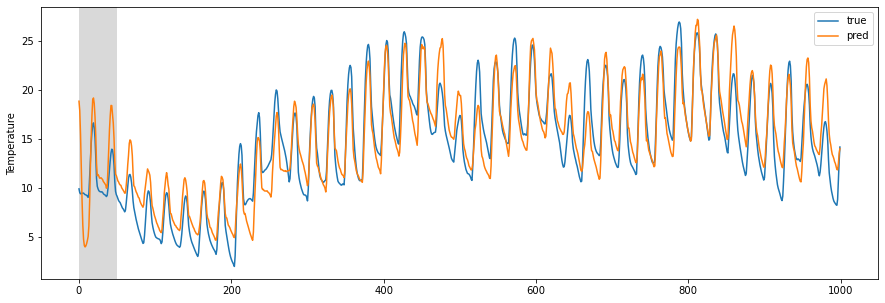

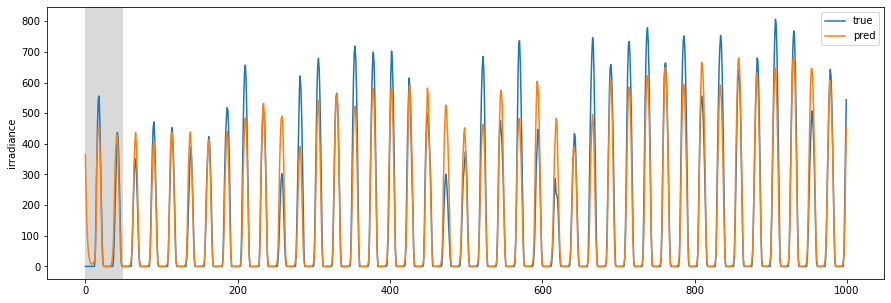

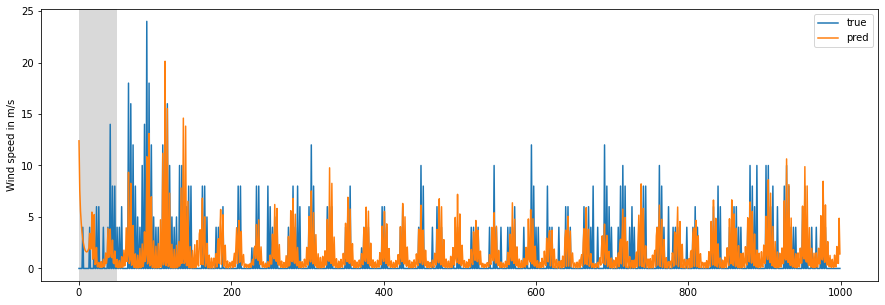

In [114]:
plot_comparison(start_idx=10000, length=1000, train=True)

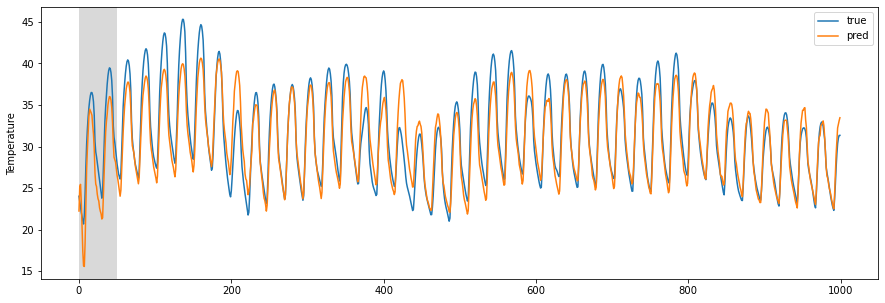

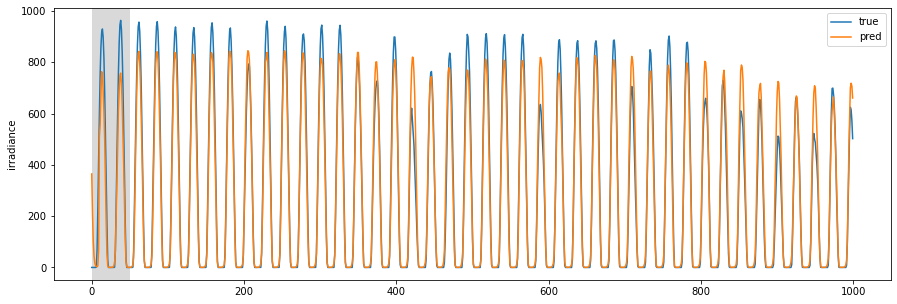

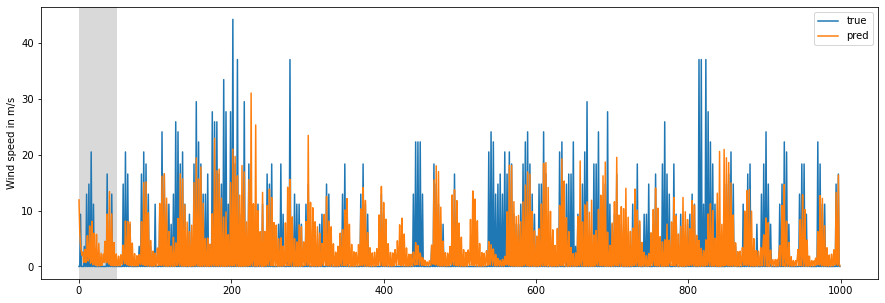

In [115]:
plot_comparison(start_idx=200, length=1000, train=False)